In [1]:
import os
from glob import glob
from tqdm.auto import tqdm
from scipy.interpolate import interp1d
from sklearn.metrics import auc

import numpy as np
import pandas as pd
import xarray as xr
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import tifffile
import spatialproteomics as sp
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# === Configuration ===
%load_ext autoreload
%autoreload 2

mpl.style.core.use('pub_matplotlib_rc.ini')

BASE_PATH = "/g/huber/users/meyerben/data/codex/BNHL/data_for_publication/"

# === Colors and Mappings ===
entity_colors = {
    'LN': '#9dcbec',
    'CLL': '#FAD0CE', 'LPL': '#EEBFBD', 'MZL': '#E2AFAC', 
    'FL 1': '#D59E9C', 'FL 2': '#C98D8B', 'FL 3a': '#BD7C7A', 'FL 3b': '#B16C69', 
    'MCL': '#A55B58', 'DLBCL': '#994A47', 'PMBCL': '#8C3937', 
    'Burkitt': '#802926', 'BLBL': '#741815'
}

entity_class_colors = {
    'LN': '#9dcbec', 'indolent': '#E2AFAC', 'aggressive': '#741815'
}

celltype_colors = {
    'B cell': '#5799d1', 'T cell': '#ebc850', 'Myeloid cell': '#de6866',
    'Dendritic cell': '#4cbcbd', 'Macrophage': '#bb7cb4',
    'Stromal cell': '#62b346', 'Endothelial cell': '#bf997d'
}

neighborhood_colors = {
    'B': '#5799d1', 'B_prol/T_fh': '#154e91', 'T/Dendritic': '#fef1c3',
    'T': '#ebc850', 'T_h/T_reg': '#cca02d', 'Myeloid/Macro': '#de6866',
    'Mixed': '#c8ceda'
}

nh_mapping_dict = {
    'Neighborhood 0': 'T/Dendritic', 'Neighborhood 1': 'T',
    'Neighborhood 2': 'Mixed', 'Neighborhood 3': 'B_prol/T_fh',
    'Neighborhood 4': 'T_h/T_reg', 'Neighborhood 5': 'B',
    'Neighborhood 6': 'Myeloid/Macro'
}

entity_grouping_dict = {
    'LN': 'LN', 'FL 1': 'indolent', 'FL 2': 'indolent', 'FL 3a': 'indolent', 
    'FL 3b': 'indolent', 'MZL': 'indolent', 'DLBCL': 'aggressive', 
    'Burkitt': 'aggressive', 'PMBCL': 'aggressive', 'BLBL': 'aggressive'
}

# === Load Metadata and Precomputed Data ===
metadata = pd.read_csv(os.path.join(BASE_PATH, "derived_data/tma_metadata.csv"), index_col=0)
files = glob(os.path.join(BASE_PATH, "tmas_unzipped/*"))

all_cts = [
    'B cell', 'B_prol', 'T cell', 'T_h', 'T_h_mem', 'T_h_naive', 'T_reg', 'T_fh',
    'T_reg_Helios', 'T_tox', 'T_exh', 'T_progenitor_exh', 'T_terminally_exh',
    'T_tox_naive', 'T_tox_mem', 'Myeloid cell', 'Dendritic cell', 'Macrophage',
    'M2', 'Stromal cell', 'Endothelial cell'
]

abundance_df = pd.read_csv(os.path.join(BASE_PATH, "derived_data/ct_abundances_level_0.csv"), index_col=0)
abundance_df = abundance_df.div(abundance_df.sum(axis=1), axis=0)
df = pd.merge(metadata, abundance_df, left_on='patient_id', right_index=True)
df['Entity'] = pd.Categorical(df['Entity'], categories=entity_colors.keys(), ordered=True)
df = df.sort_values(by=['Entity', 'B cell'])

# === Load Sample Data ===
sample_dict = {}
sample_to_patient_dict = {}

for _, (sample_id_a, sample_id_b, patient_id) in tqdm(df[['sample_id_a', 'sample_id_b', 'patient_id']].iterrows()):
    for sample_id in [sample_id_a, sample_id_b]:
        if pd.isna(sample_id):
            continue
        sample_to_patient_dict[sample_id] = patient_id
        matches = [f for f in files if f"{sample_id}.zarr" in f]
        if len(matches) != 1:
            raise ValueError(f"Sample {sample_id} has ambiguous files: {matches}")
        sample_dict[sample_id] = xr.open_zarr(matches[0])

patient_to_entity_mapping = dict(zip(df['patient_id'], df['Entity']))

0it [00:00, ?it/s]

In [3]:
# === Ripley's K Summary ===
df_alphabet = pd.read_csv(os.path.join(BASE_PATH, "derived_data/alphabet.csv"), index_col=0)
df_alphabet['patient'] = [sample_to_patient_dict['_'.join(x.rsplit('_')[:3])] for x in df_alphabet['sample']]
df_alphabet['entity'] = df_alphabet['patient'].map(patient_to_entity_mapping)
df_alphabet['entity_class'] = df_alphabet['entity'].map(entity_grouping_dict)

summary_stats = []
for (sample, cell_type), group in df_alphabet.groupby(['sample', 'CA']):
    group = group.sort_values('K.function.r')
    mask = (group['K.function.r'] > 0) & (group['K.function.r'] <= 300)
    delta = group['K.function.border'] - group['K.function.theo']
    auc_val = auc(group['K.function.r'][mask], delta[mask])
    max_dev = delta.max()
    entity = group['entity'].iloc[0]
    entity_class = group['entity_class'].iloc[0]
    summary_stats.append({
        'sample': sample, 'cell_type': cell_type,
        'auc': auc_val, 'max_dev': max_dev,
        'entity': entity, 'entity_class': entity_class
    })

df_summary = pd.DataFrame(summary_stats)
df_summary['entity_class'] = pd.Categorical(df_summary['entity_class'], categories=entity_class_colors.keys(), ordered=True)
df_summary['cell_type'] = pd.Categorical(df_summary['cell_type'], categories=all_cts, ordered=True)
df_summary = df_summary.sort_values(by=['cell_type', 'entity_class'])

# === Interpolation Function ===
def interpolate_ripley_data(df, x_common):
    interpolated = []
    for (sample, entity_class), group in df.groupby(['sample', 'entity_class']):
        group = group.sort_values('K.function.r')
        if len(group) < 2:
            continue
        f = interp1d(group['K.function.r'], group['K.function.border'], bounds_error=False, fill_value=np.nan)
        y_interp = f(x_common)
        interpolated.append(pd.DataFrame({
            'K.function.r': x_common,
            'K.function.border': y_interp,
            'entity_class': entity_class,
            'sample': sample
        }))
    return pd.concat(interpolated, ignore_index=True)

In [4]:
# instead of having one auc per sample, we want one per patient by taking the mean auc of the replicates

# Step 1: Create a dictionary mapping patient_id to sample IDs
histo_to_samples = {}
for _, row in metadata.iterrows():
    samples = [row['sample_id_a'], row['sample_id_b']]
    samples = [sample for sample in samples if pd.notna(sample)]
    histo_to_samples[row['patient_id']] = samples

# Step 2: Transform the second dataframe
# Create a new dataframe where each column is a Histo-Nr
histo_df = pd.DataFrame()

for histo_nr, samples in tqdm(histo_to_samples.items()):
    # Filter the dataframe for the samples corresponding to the current Histo-Nr
    filtered_df = df_summary[df_summary['sample'].isin(samples)]
    
    # Select only numeric columns for aggregation
    numeric_columns = filtered_df.select_dtypes(include=[np.number]).columns
    numeric_df = filtered_df[['cell_type', 'entity', 'entity_class'] + list(numeric_columns)]
    
    # Aggregate using the mean, explicitly setting observed=False
    aggregated_df = numeric_df.groupby(['cell_type', 'entity', 'entity_class'], observed=True).mean().reset_index()
        
    # Add a column for the Histo-Nr
    aggregated_df['patient_id'] = histo_nr
        
    # Append to the new dataframe
    histo_df = pd.concat([histo_df, aggregated_df], ignore_index=True)

df_summary = histo_df

  0%|          | 0/132 [00:00<?, ?it/s]

In [5]:
font_size = 6.5
point_size = 20
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

In [6]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Get unique cell types from your DataFrame
cell_types = df_summary['cell_type'].unique()

# List to store results as tuples: (cell_type, original_p_value)
results = []

# Loop over each cell type and perform ANOVA on AUC by entity_class
for cell in cell_types:
    # Subset the data to only include the current cell type
    df_subset = df_summary[df_summary['cell_type'] == cell]
    
    # Ensure that there is more than one entity class present before testing
    if df_subset['entity_class'].nunique() < 2:
        print(f"Skipping {cell}: Not enough groups for ANOVA.")
        continue
    
    # Fit the linear model with entity_class as a categorical variable
    model = smf.ols('auc ~ C(entity_class)', data=df_subset).fit()
    
    # Run the ANOVA on the model (using Type II sums of squares)
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Get the p-value for the effect of entity_class
    # The row name is 'C(entity_class)' because of the formula.
    p_value = anova_table.loc['C(entity_class)', 'PR(>F)']
    
    results.append((cell, p_value))

# Convert the results to a DataFrame for easier handling
results_df = pd.DataFrame(results, columns=['cell_type', 'p_value'])

# Apply Benjamini-Hochberg correction to the list of p-values
reject, pvals_corrected, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')

# Add the corrected p-values and the rejection decision to the DataFrame
results_df['p_value_corrected'] = pvals_corrected
results_df['reject_null'] = reject

print("Summary of ANOVA p-values and Benjamini-Hochberg corrected p-values:")
print(results_df)

Skipping T_exh: Not enough groups for ANOVA.
Summary of ANOVA p-values and Benjamini-Hochberg corrected p-values:
           cell_type       p_value  p_value_corrected  reject_null
0             B cell  6.444237e-19       1.288847e-17         True
1             B_prol  3.709347e-15       3.709347e-14         True
2                T_h  3.862176e-01       4.291306e-01        False
3            T_h_mem  1.358575e-01       1.698219e-01        False
4          T_h_naive  9.882015e-01       9.882015e-01        False
5              T_tox  9.047912e-02       1.292559e-01        False
6        T_tox_naive  5.126465e-02       8.544108e-02        False
7          T_tox_mem  3.564461e-02       6.480838e-02        False
8       Myeloid cell  1.283513e-04       5.134050e-04         True
9     Dendritic cell  8.018900e-02       1.233677e-01        False
10        Macrophage  4.255794e-04       1.418598e-03         True
11                M2  1.223603e-02       2.719117e-02         True
12      Stromal

In [7]:
df_summary['cell_type'].cat.categories

Index(['B cell', 'B_prol', 'T cell', 'T_h', 'T_h_mem', 'T_h_naive', 'T_reg',
       'T_fh', 'T_reg_Helios', 'T_tox', 'T_exh', 'T_progenitor_exh',
       'T_terminally_exh', 'T_tox_naive', 'T_tox_mem', 'Myeloid cell',
       'Dendritic cell', 'Macrophage', 'M2', 'Stromal cell',
       'Endothelial cell'],
      dtype='object')

/scratch/jobs/37661039/ipykernel_3891179/883847670.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(formatted_labels, fontsize=font_size)


No p-value found for T_exh


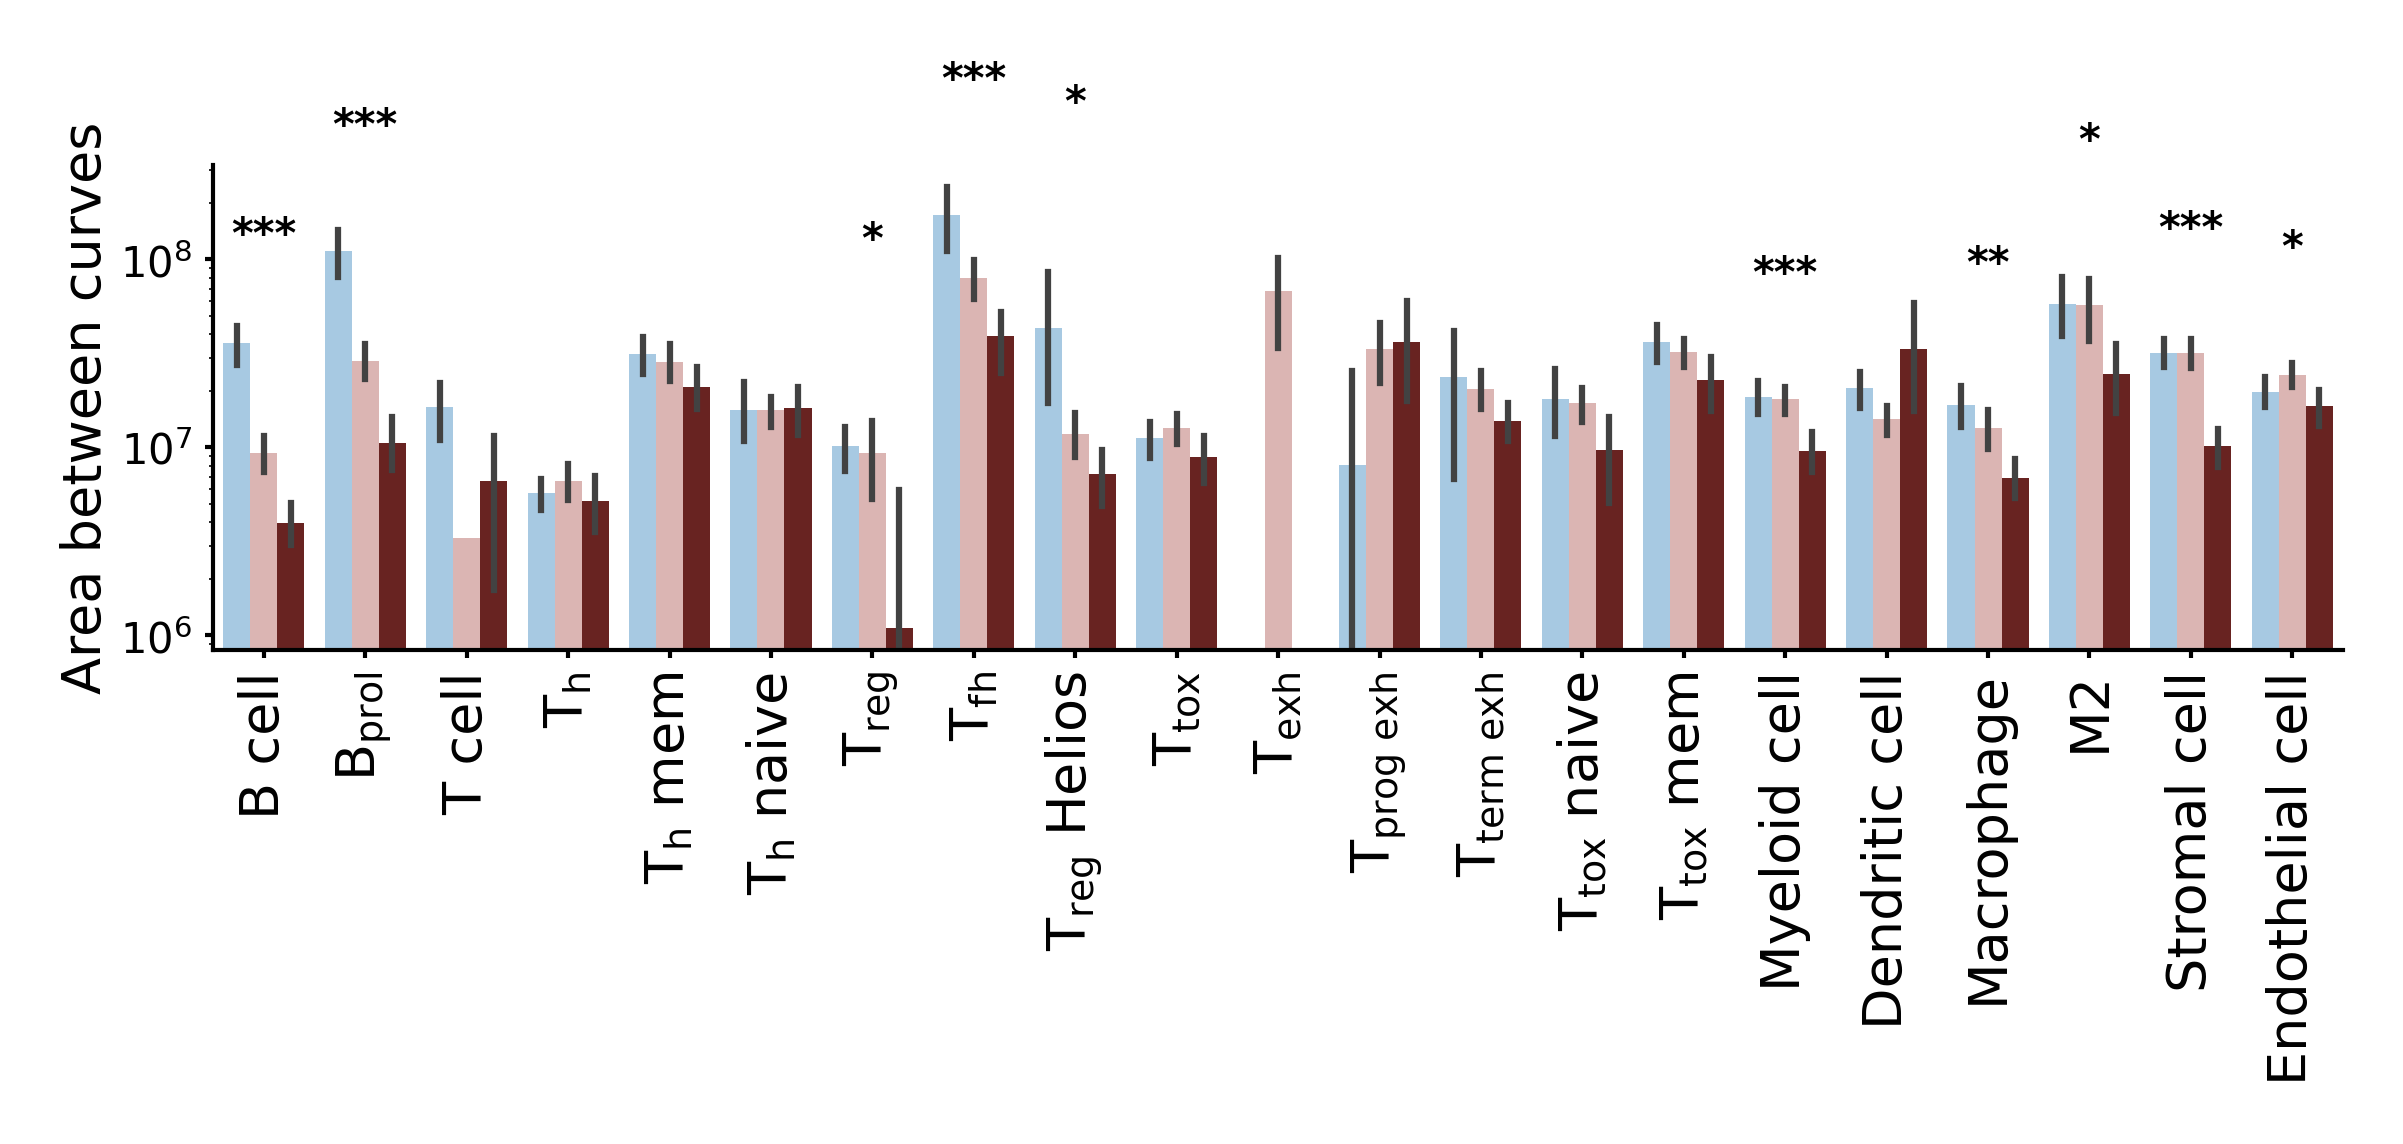

In [8]:
formatted_dict = {
    'B cell': 'B cell',
    'B_prol': r'B$_{\mathrm{prol}}$',
    'Dendritic cell': 'Dendritic cell',
    'Endothelial cell': 'Endothelial cell',
    'M2': 'M2',
    'Macrophage': 'Macrophage',
    'Myeloid cell': 'Myeloid cell',
    'Stromal cell': 'Stromal cell',
    'T_fh': r'T$_{\mathrm{fh}}$',
    'T_h': r'T$_{\mathrm{h}}$',
    'T_h_mem': r'T$_{\mathrm{h}}$ mem',
    'T_h_naive': r'T$_{\mathrm{h}}$ naive',
    'T_terminally_exh': r'T$_{\mathrm{term\ exh}}$',
    'T_tox': r'T$_{\mathrm{tox}}$',
    'T_tox_mem': r'T$_{\mathrm{tox}}$ mem',
    'T_tox_naive': r'T$_{\mathrm{tox}}$ naive',
    'T_reg': r'T$_{\mathrm{reg}}$',
    'T_progenitor_exh': r'T$_{\mathrm{prog\ exh}}$',
    'T_reg_Helios': r'T$_{\mathrm{reg}}$ Helios',
    'T cell': 'T cell',
    'T_exh': r'T$_{\mathrm{exh}}$'
}

def plot_ripleys_auc(ax):
    # Draw the barplot
    sns.barplot(
        data=df_summary, 
        x='cell_type', 
        y='auc', 
        hue='entity_class', 
        palette=entity_class_colors, 
        ax=ax, 
        legend=False
    )
    
    ax.set_ylabel('Area between curves', fontsize=font_size)
    ax.set_xlabel('')
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)  

    # Get and format x-tick labels
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    formatted_labels = [formatted_dict.get(label, label) for label in xtick_labels]
    ax.set_xticklabels(formatted_labels, fontsize=font_size)
    
    # Rotate the x-tick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_horizontalalignment('center')
        label.set_verticalalignment('top')
        
    ax.set_yscale('log')

    # ======= Add ANOVA significance annotations =======
    for idx, cell in enumerate(df_summary['cell_type'].cat.categories):
        try:
            p_val = results_df.loc[results_df['cell_type'] == cell, 'p_value_corrected'].values[0]

            # Determine significance level
            if p_val < 0.001:
                significance = "***"
            elif p_val < 0.01:
                significance = "**"
            elif p_val < 0.05:
                significance = "*"
            else:
                significance = ""

            # Find x position (cell type index)
            if significance:
                ax.text(
                    idx,  # X position
                    df_summary[df_summary['cell_type'] == cell]['auc'].max() * 1.1,  # Y position (above bars)
                    significance, 
                    ha='center', 
                    va='bottom', 
                    fontsize=5, 
                    fontweight='bold', 
                    color='black'
                )
        except IndexError:
            print(f"No p-value found for {cell}")
    

plt.figure(figsize=(4, 2), dpi=600)
ax = plt.gca()
plot_ripleys_auc(ax)
plt.tight_layout()

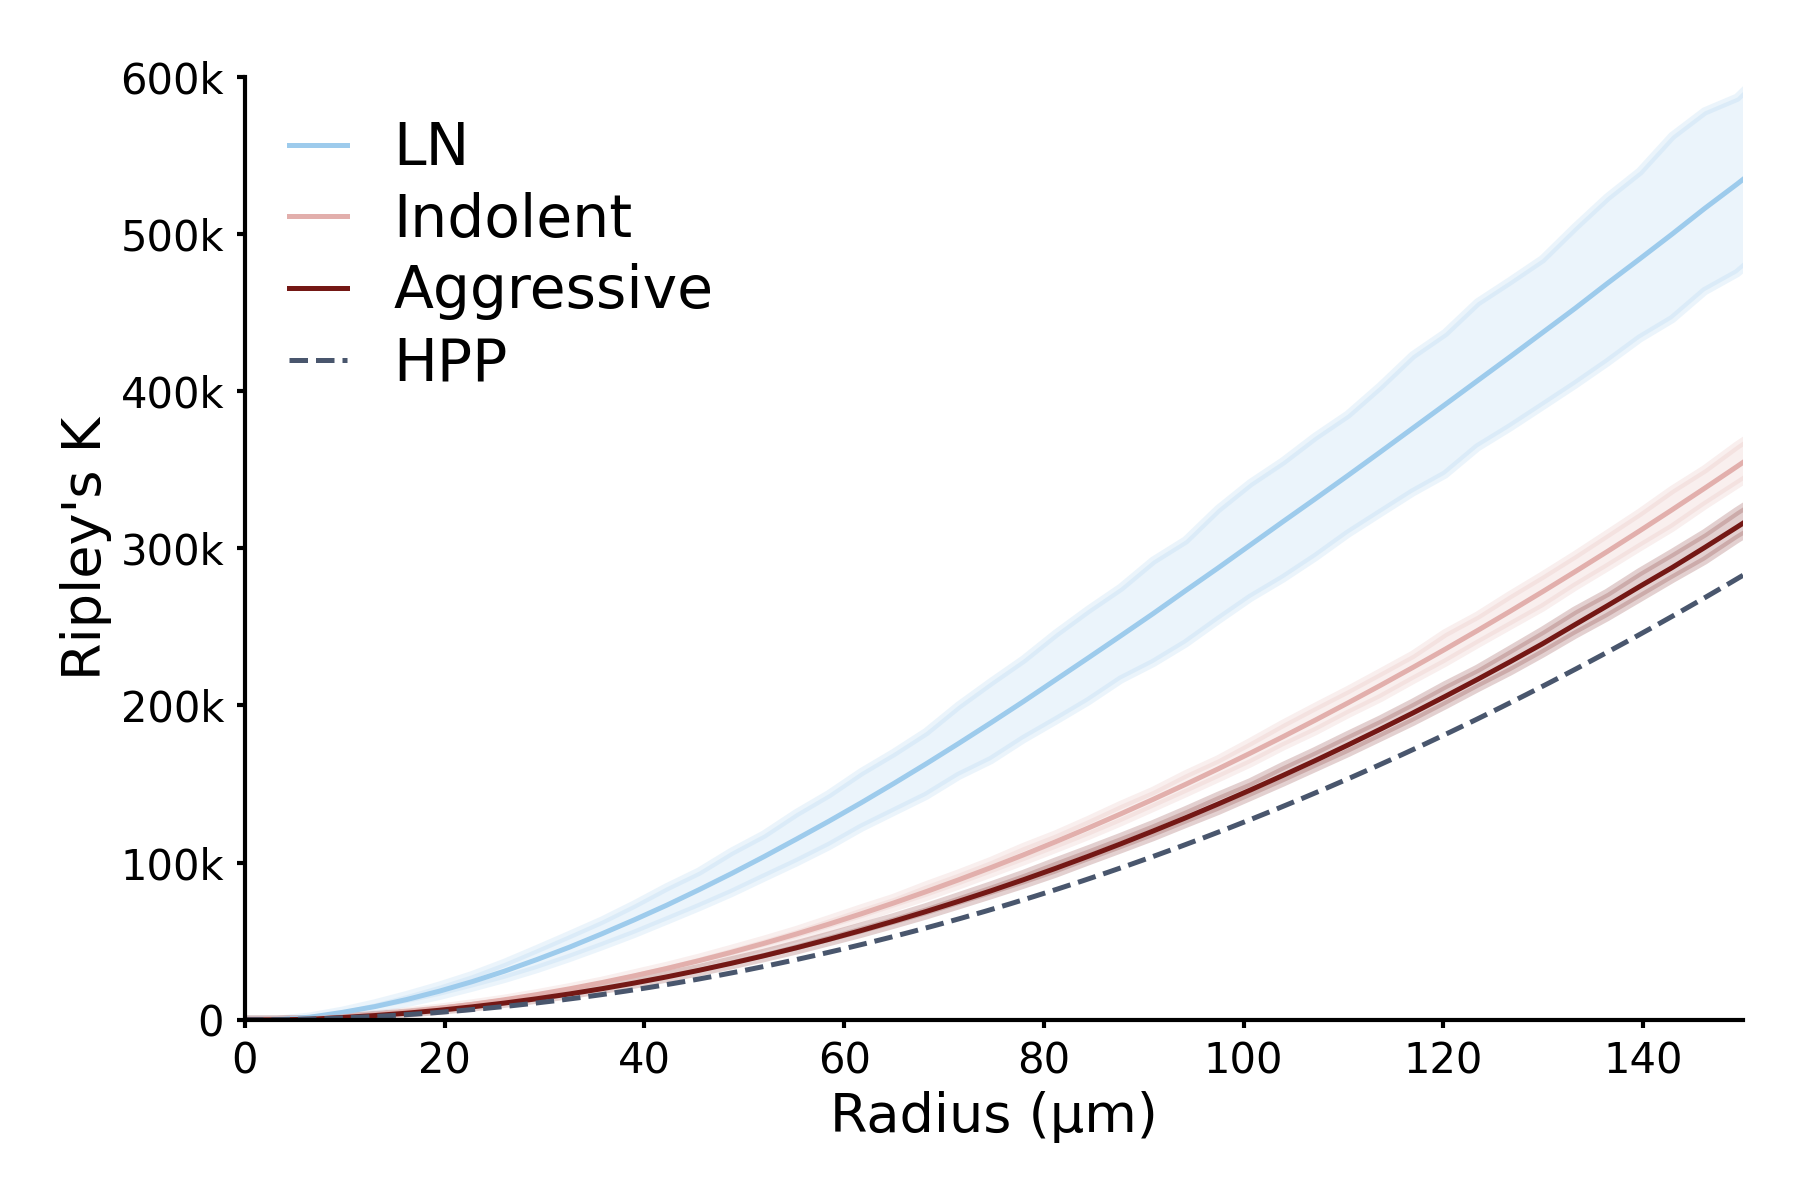

In [9]:
import matplotlib.ticker as ticker

# Format x-axis ticks to show 8k, 10k, etc.
def format_ticks(x, pos):
    if x >= 1000:
        return f'{int(x/1000)}k'
    return str(int(x)) 

def plot_ripleys_single_ct(ax, celltype="B cell"):
    df_cell_type = df_alphabet[df_alphabet['CA'] == celltype].reset_index(drop=True)

    # Create a common x-axis (radii) based on min/max of all samples)
    all_radii = df_cell_type['K.function.r'].values
    x_common = np.linspace(np.nanmin(all_radii), np.nanmax(all_radii), 100)  # 100 points

    # Interpolate all samples onto the common x-axis
    df_interpolated = interpolate_ripley_data(df_cell_type, x_common)
    
    # turning the radius into microns
    df_interpolated['K.function.r'] = df_interpolated['K.function.r'] / 2
    df_cell_type['K.function.r'] = df_cell_type['K.function.r'] / 2

    # Plot aggregated curves with confidence intervals
    sns.lineplot(
        data=df_interpolated,
        x='K.function.r',
        y='K.function.border',
        hue='entity_class',
        linewidth=line_width,
        hue_order=entity_class_colors.keys(),
        palette=entity_class_colors,  # Use your predefined palette
        ax=ax,
        legend=True
    )

    # Overlay theoretical curve (assuming it's the same for all samples)
    sns.lineplot(
        data=df_cell_type.drop_duplicates(subset=['K.function.r']),
        x='K.function.r',
        y='K.function.theo',
        color=point_border_color,
        linewidth=line_width,
        linestyle='--',
        ax=ax,
        label='HPP',
        legend=False
    )
    
    # Customize the legend
    legend = ax.legend(
        loc='upper left',      # Place legend in the top left
        bbox_to_anchor=(0, 1),  # Adjust position if needed
        fontsize=7
    )
    
    for text in legend.get_texts():
        label = text.get_text()
        text.set_text(label[0].upper() + label[1:] if label else label)  # Capitalizes only the first letter

    # ax.set_title(f'Cell Type: {celltype}')
    ax.set_xlabel('Radius (µm)', fontsize=font_size)
    ax.set_ylabel(f"Ripley's K", fontsize=font_size)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 600000)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
    #ax.legend(title='Entity Class')
    ax.spines['top'].set_visible(False)    # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    
plt.figure(figsize=(3, 2), dpi=600)
ax = plt.gca()
plot_ripleys_single_ct(ax)
plt.tight_layout()

In [10]:
df = pd.read_csv(os.path.join(BASE_PATH, "derived_data/squidpy_df.csv"), index_col=0)

def plot_squidpy_results(ax, entity_class='LN', show_y_labels=True, show_cbar=True, row_order=celltype_colors.keys(), col_order=celltype_colors.keys()):
    adata_df = df.copy()
    adata_df = adata_df[adata_df['entity_class'] == entity_class]
    adata_df = adata_df[['ct1', 'ct2', 'interaction_score']]

    # Group by phenotype and neighbour_phenotype, then compute the mean
    heatmap_data = adata_df.groupby(['ct1', 'ct2'])['interaction_score'].mean().unstack()
    
    # **Set row and column order**
    if row_order is not None:
        heatmap_data = heatmap_data.reindex(index=row_order)
    if col_order is not None:
        heatmap_data = heatmap_data.reindex(columns=col_order)

    # Plot heatmap
    sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, center=0, cbar=show_cbar, ax=ax, 
                linewidths=line_width, square=True, vmin=-200, vmax=200, 
                cbar_kws={'label': 'Interaction Score'})
    
    # Format x-tick labels
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    formatted_labels = [formatted_dict.get(label, label) for label in xtick_labels]
    ax.set_xticklabels(formatted_labels, fontsize=font_size)

    # Format y-tick labels
    ytick_labels = [label.get_text() for label in ax.get_yticklabels()]
    formatted_labels = [formatted_dict.get(label, label) for label in ytick_labels]
    ax.set_yticklabels(formatted_labels, fontsize=font_size)

    ax.set_xlabel("")
    ax.set_ylabel("")
    if not show_y_labels:
        ax.set_yticks([])
        
    entity_class_label = entity_class[0].upper() + entity_class[1:]  # Capitalizes only the first letter
    ax.set_title(entity_class_label, fontsize=font_size)

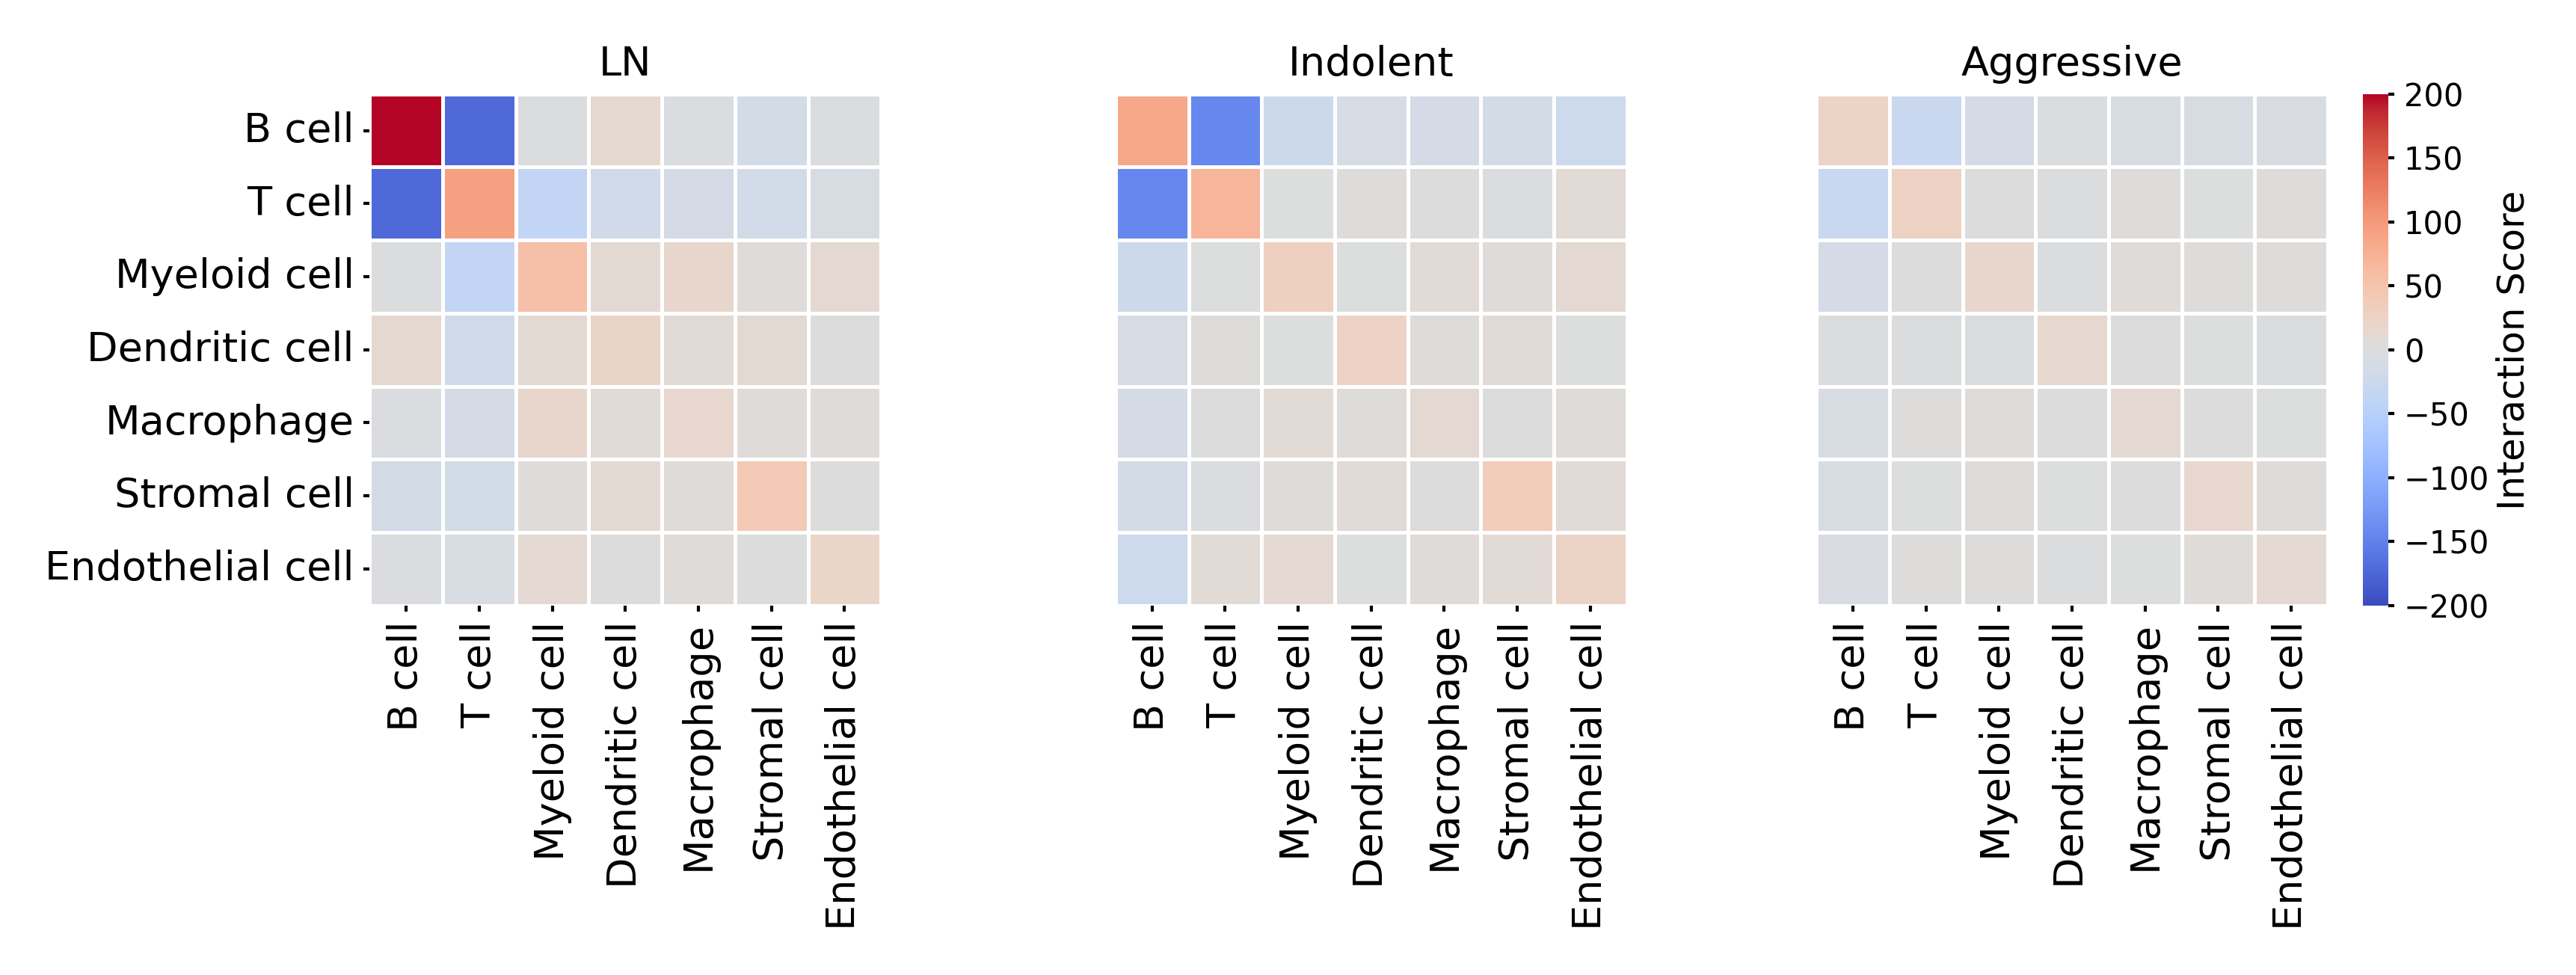

In [11]:
# setting a min and max here so that all of the heatmaps have the same scaling
fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=600)
plot_squidpy_results(ax[0], entity_class='LN', show_cbar=False)
plot_squidpy_results(ax[1], entity_class='indolent', show_y_labels=False, show_cbar=False)
plot_squidpy_results(ax[2], entity_class='aggressive', show_y_labels=False)
plt.tight_layout()

In [12]:
# Ripley's cross

# this df is 15GB large, hence it will take some time to load (also should do this in an interactive session)
df_alphabet_cross = pd.read_csv(os.path.join(BASE_PATH, "derived_data/alphabet_cross.csv"), index_col=0)
df_alphabet_cross['patient'] = [sample_to_patient_dict['_'.join(x.rsplit('_')[:3])] for x in df_alphabet_cross['sample']]
df_alphabet_cross['entity'] = [patient_to_entity_mapping[x] for x in df_alphabet_cross['patient']]
df_alphabet_cross['entity_class'] = [entity_grouping_dict[x] for x in df_alphabet_cross['entity']]
df_alphabet_cross['ct_combination'] = [f"{x['CA']} - {x['CB']}" for i, x in df_alphabet_cross.iterrows()]

In [13]:
summary_stats = []
for (sample, cell_type), group in df_alphabet_cross.groupby(['sample', 'ct_combination']):
    # here, we filter to a certain range in order to avoid small or large scale effects skewing the whole thing
    r_min = 0
    r_max = 300  # Set biologically relevant r_max
    #r_max = group['K.function.r'].max()
    mask = group['Kcross.r'] > r_min
    mask = group['Kcross.r'] <= r_max
    
    delta = group['Kcross.border'] - group['Kcross.theo']
    auc_value = auc(group['Kcross.r'][mask], delta[mask])
    max_dev = delta.max()
    entity = group['entity'].unique()
    entity_class = group['entity_class'].unique()
    if len(entity) != 1 or len(entity_class) != 1:
        raise ValueError(f'Found multiple entities: {len(entity)}, {len(entity_class)}')
    summary_stats.append({
        'sample': sample,
        'cell_type': cell_type,
        'auc': auc_value,
        'max_dev': max_dev,
        'entity': entity[0],
        'entity_class': entity_class[0]
    })

# Convert to DataFrame and plot
df_summary = pd.DataFrame(summary_stats)

# Define the custom order based on entity_class_colors keys
custom_order = list(entity_class_colors.keys())

# Convert 'entity_class' to a categorical variable with the custom order
df_summary['entity_class'] = pd.Categorical(
    df_summary['entity_class'], 
    categories=custom_order, 
    ordered=True
)

# Sort the DataFrame by 'entity_class'
df_summary = df_summary.sort_values(by=['entity_class'])

# removing NAs and extreme values
df_summary = df_summary.dropna(subset=['auc', 'entity_class'])
df_summary = df_summary[np.isfinite(df_summary['auc'])]

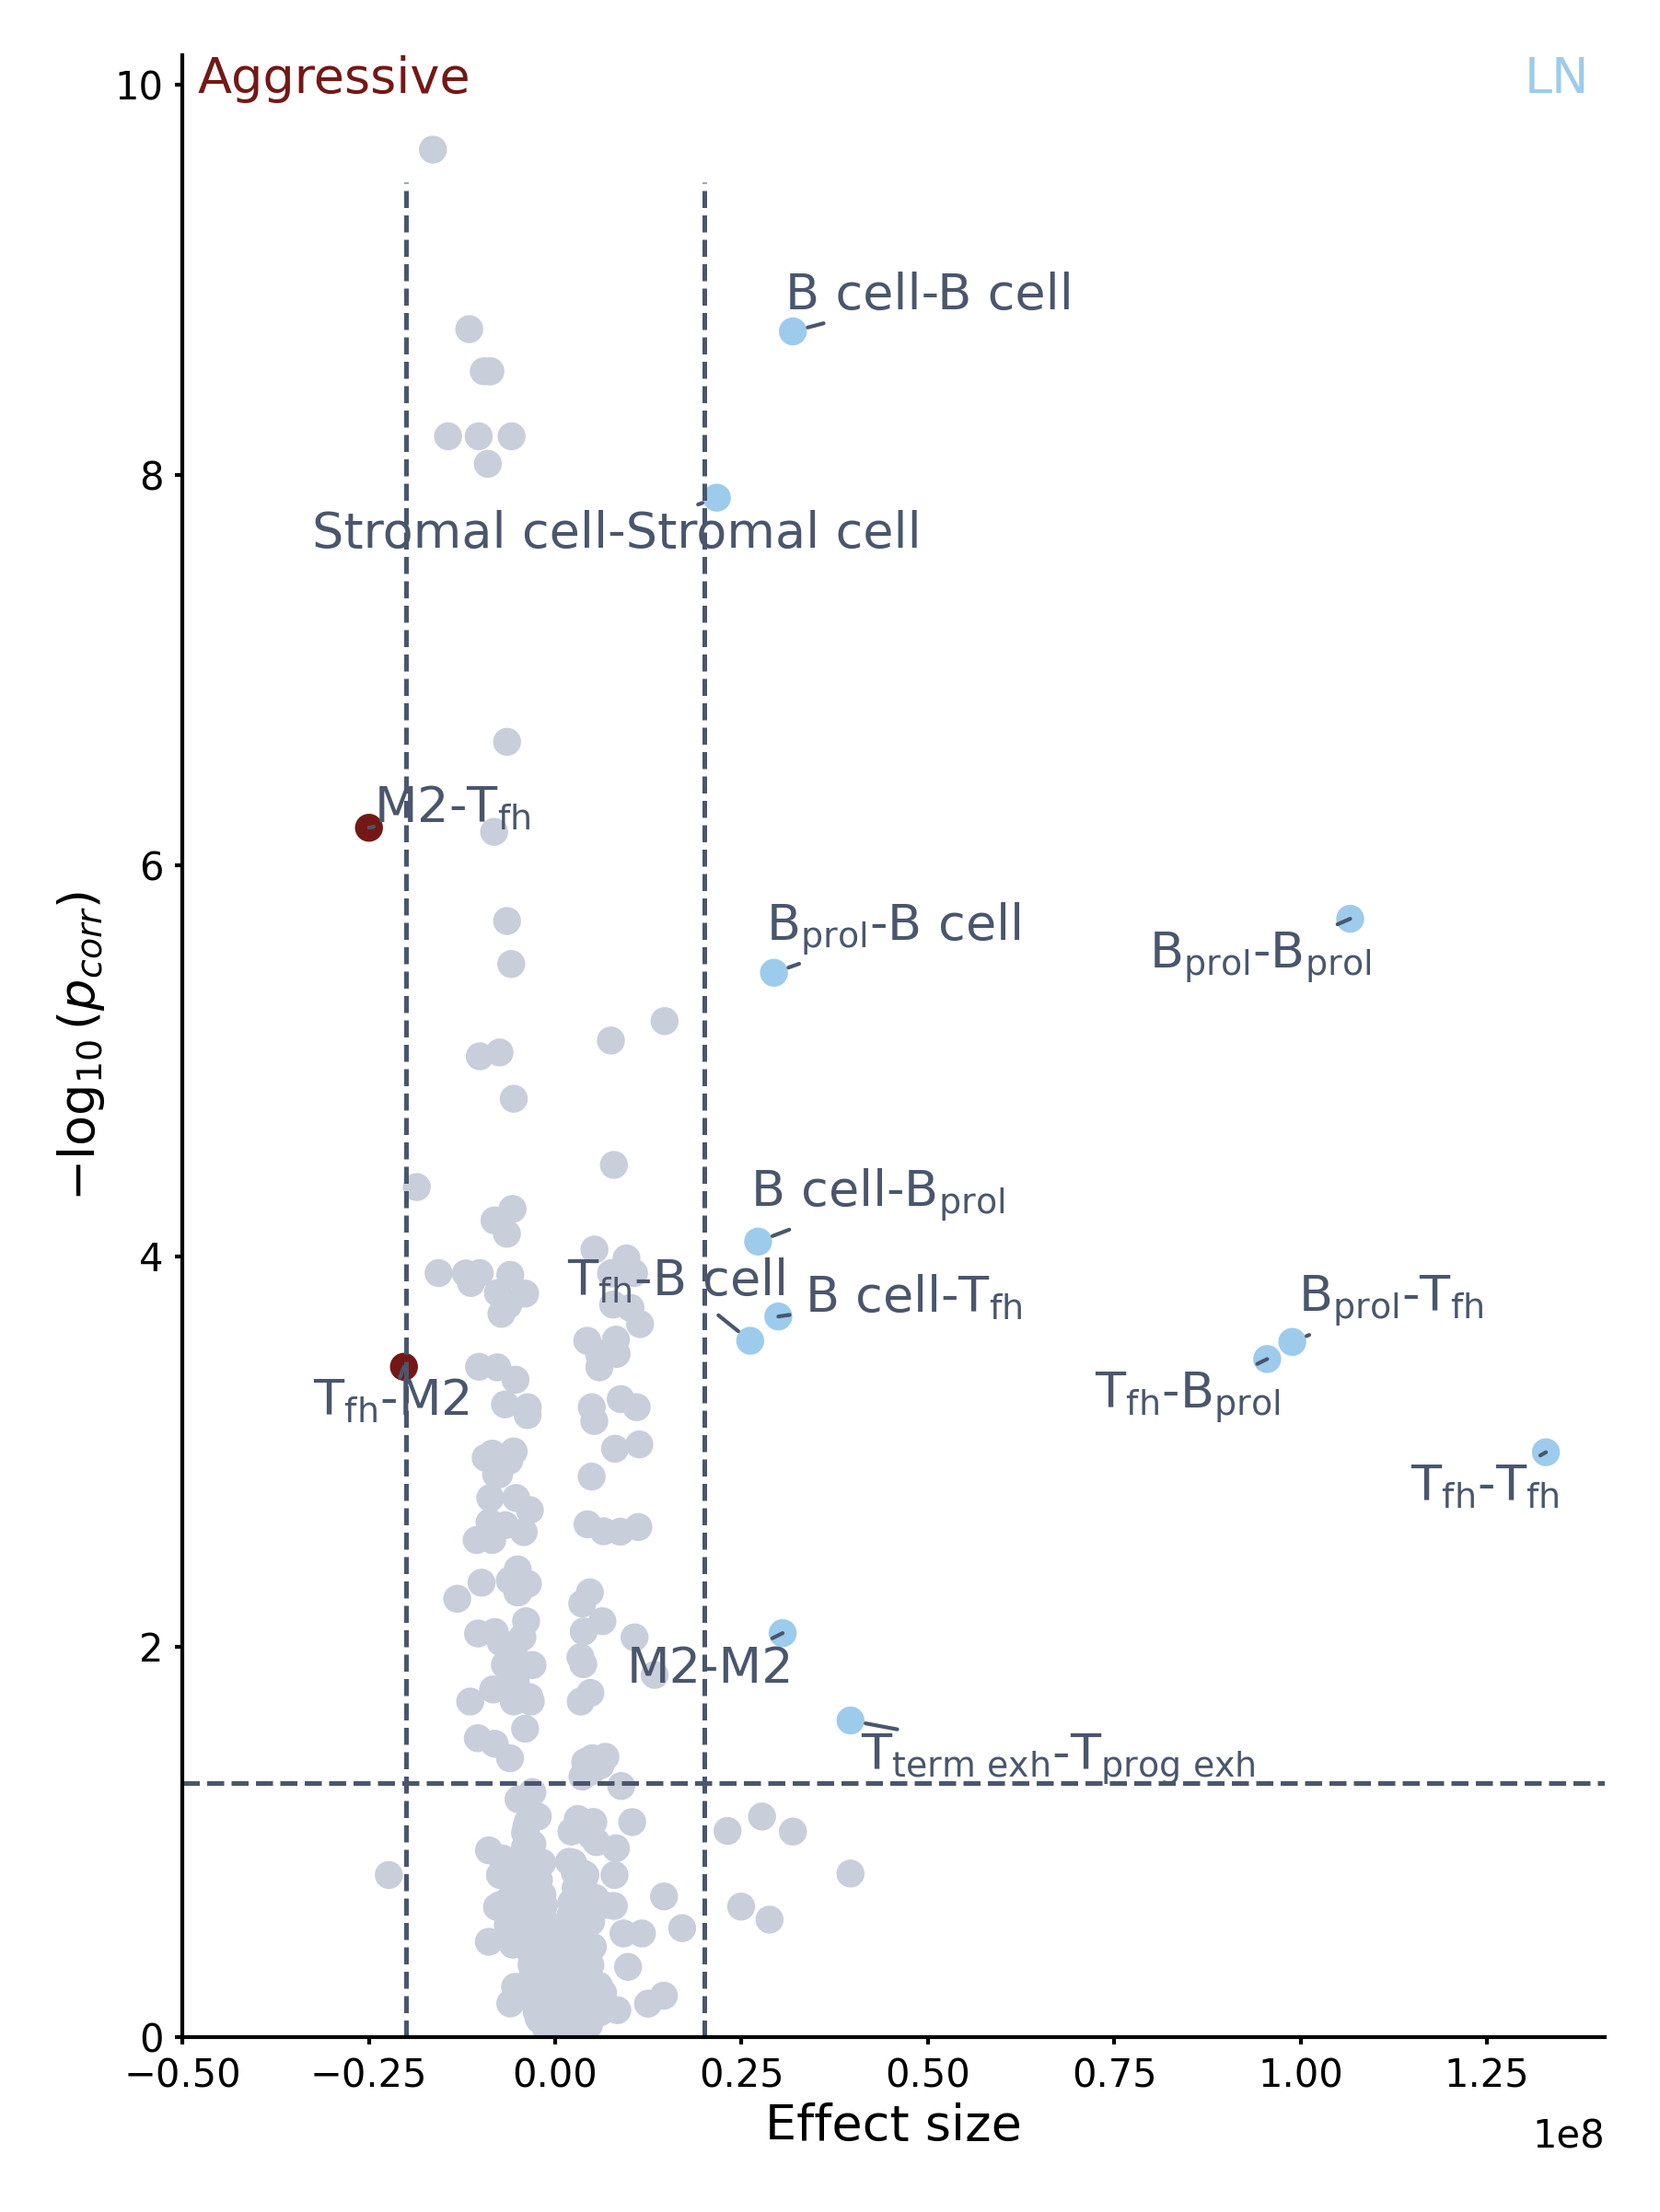

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

point_size = 7

# Filter for the two entity classes of interest: LN and aggressive
df_filtered = df_summary[df_summary['entity_class'].isin(['LN', 'aggressive'])].copy()

# List to store results for each cell type
results = []

# Loop over each unique cell type
for cell in df_filtered['cell_type'].unique():
    df_cell = df_filtered[df_filtered['cell_type'] == cell]
    df_ln = df_cell[df_cell['entity_class'] == 'LN']
    df_aggressive = df_cell[df_cell['entity_class'] == 'aggressive']
    
    # Skip if not enough data for either group
    if len(df_ln) < 2 or len(df_aggressive) < 2:
        continue

    # Compute mean AUC for each group
    mean_ln = df_ln['auc'].mean()
    mean_aggressive = df_aggressive['auc'].mean()
    
    # Effect size: difference in means (LN minus aggressive)
    effect = mean_ln - mean_aggressive
    
    # Perform independent t-test (Welch's t-test)
    t_stat, p_val = ttest_ind(df_ln['auc'], df_aggressive['auc'], equal_var=False)
    
    results.append({
        'cell_type': cell,
        'effect': effect,
        'p_value': p_val
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Apply Benjamini-Hochberg correction
alpha = 0.05
reject, pvals_corrected, _, _ = multipletests(results_df['p_value'], alpha=alpha, method='fdr_bh')
results_df['p_value_corrected'] = pvals_corrected
results_df['reject_null'] = reject

# Calculate -log10(corrected p-value) for plotting
results_df['neg_log10_p'] = -np.log10(results_df['p_value_corrected'])

# Define thresholds
p_threshold = alpha           # significance cutoff for corrected p-values
effect_threshold = 20000000        # minimum absolute effect size to consider

# Flag significant points
results_df['significant'] = (results_df['reject_null']) & (results_df['effect'].abs() > effect_threshold)

# --- Volcano Plot ---
plt.figure(figsize=(3, 4), dpi=600)
ax = plt.gca()

# Choose colors based on significance
# For example, red if significant, grey if not
colors = np.where(
    (results_df['significant'] & (results_df['effect'] > effect_threshold)), entity_class_colors['LN'],  # Blue for positive effect
    np.where(
        (results_df['significant'] & (results_df['effect'] < -effect_threshold)), entity_class_colors['aggressive'],  # Red for negative effect
        '#c8ceda'  # Gray for non-significant points
    )
)

# Plot points
scatter = ax.scatter(
    results_df['effect'], 
    results_df['neg_log10_p'], 
    c=colors, 
    s=point_size, 
    # edgecolor=point_border_color
)

# Annotate points only if they pass both thresholds
texts = []
for i, row in results_df.iterrows():
    if (row['p_value_corrected'] < p_threshold) and (abs(row['effect']) > effect_threshold):
        text = row['cell_type'].replace(' - ', '-')
        for k, v in formatted_dict.items():
            text = text.replace(k, v)
        txt = ax.text(
            row['effect'], row['neg_log10_p'], text,
            fontsize=font_size, color=point_border_color, ha='center', va='center'
        )
        texts.append(txt)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color=point_border_color, lw=0.5))

# Add threshold lines:
# Vertical threshold lines, limited to y=9
ax.plot([effect_threshold, effect_threshold], [0, 9.5], color=point_border_color, linestyle='--', linewidth=line_width)
ax.plot([-effect_threshold, -effect_threshold], [0, 9.5], color=point_border_color, linestyle='--', linewidth=line_width)
# Horizontal line at -log10(p_threshold)
ax.axhline(y=-np.log10(p_threshold), color=point_border_color, linestyle='--', linewidth=line_width)

# setting xlims manually
ax.set_xlim(min(-50_000_000, ax.get_xlim()[0]), ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
padding = 2_000_000
# Lower left: negative effect => "Aggressive enriched"
ax.text(xmin + padding, ymax, "Aggressive", ha='left', va='top', fontsize=font_size, color=entity_class_colors['aggressive'])
# Lower right: positive effect => "LN enriched"
ax.text(xmax - padding, ymax, "LN", ha='right', va='top', fontsize=font_size, color=entity_class_colors['LN'])


# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels and title
ax.set_xlabel('Effect size', fontsize=font_size)
ax.set_ylabel(r'$-\log_{10}(p_{corr})$', fontsize=font_size)

plt.tight_layout()

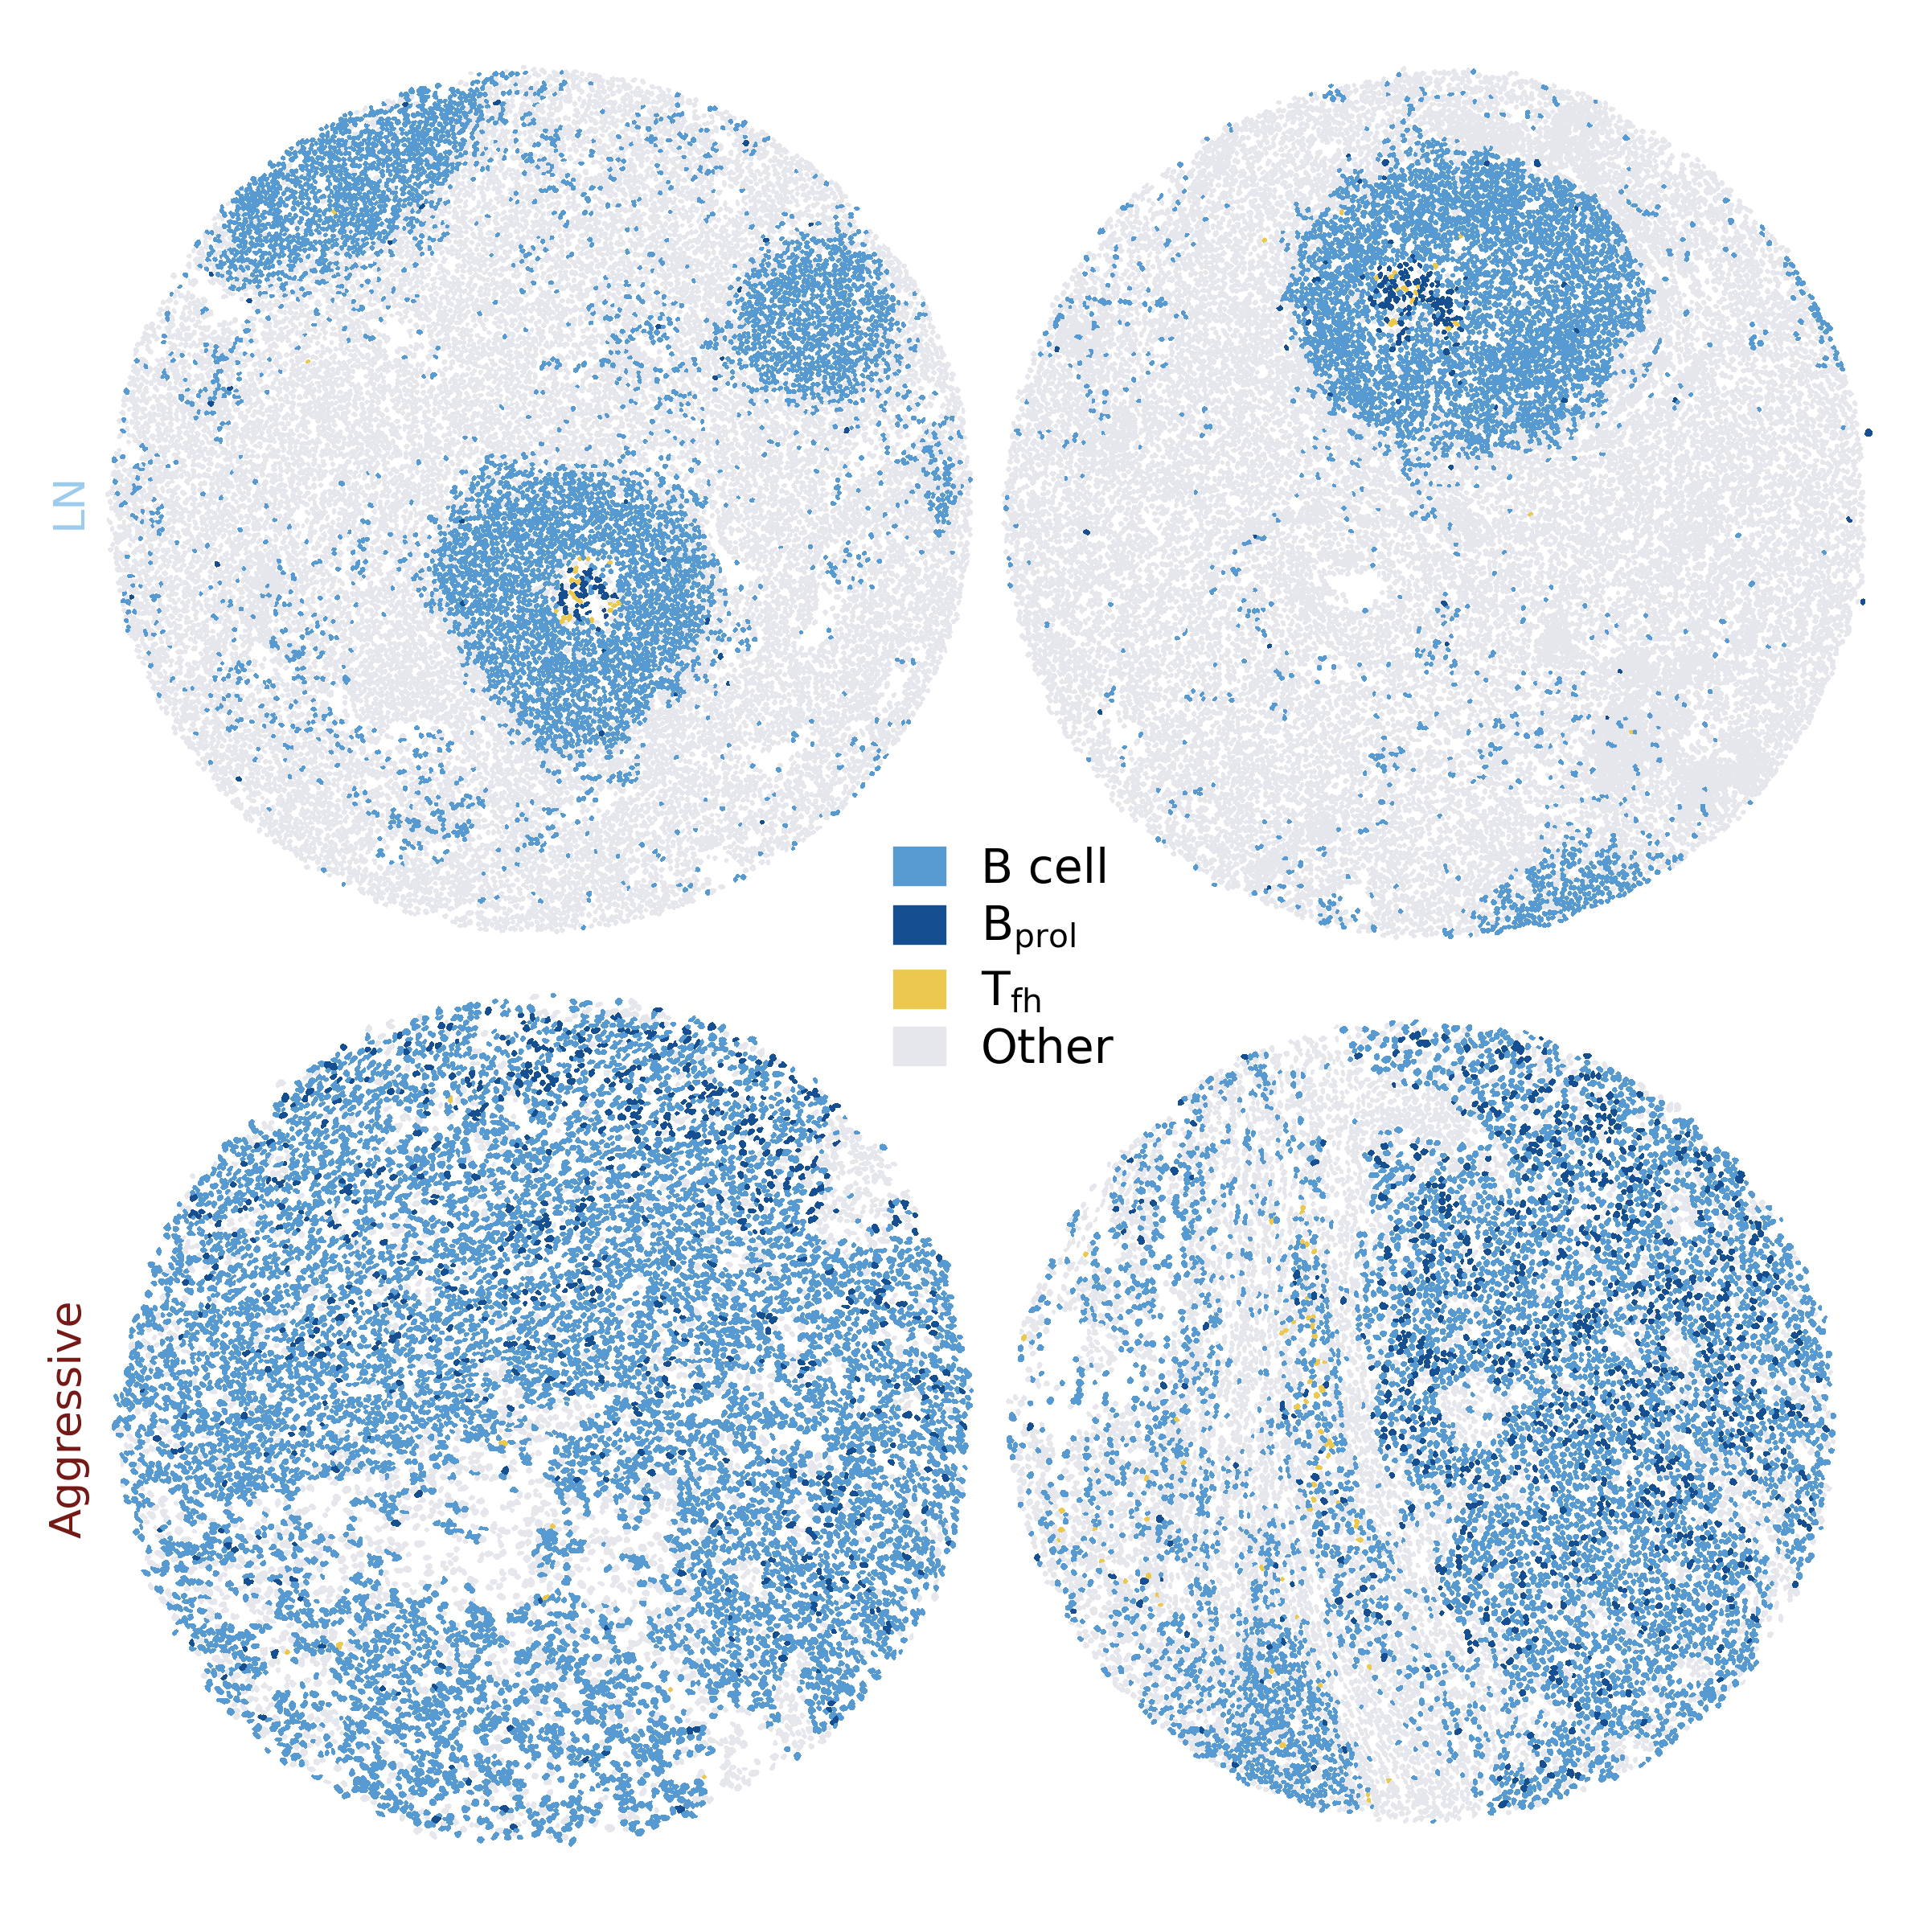

In [15]:
import matplotlib.patches as mpatches

def plot_sample(ax, sample_id):
    ds = sample_dict[sample_id]
    # showing the plot
    ct_cols_tmp = {'T_fh': '#ebc850', 'B cell': '#5799d1', 'B_prol': '#154e91'}
    celltype_colors_tmp = {x: ct_cols_tmp.get(x, '#e6e6ed') for x in ds.pp.get_layer_as_df()['_labels'].unique()}
    _ = ds.pl.autocrop().la.set_label_colors(celltype_colors_tmp.keys(), celltype_colors_tmp.values()).pl.show(render_image=False, render_labels=True, background='white', legend_label=False, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
        
fig, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=600, gridspec_kw={'wspace': 0, 'hspace': 0})
ax = ax.flatten()

# LN
plot_sample(ax[0], 'LN_20_2')
plot_sample(ax[1], 'LN_20_1')
ax[0].set_ylabel('LN', fontsize=font_size, color=entity_class_colors['LN'])

# aggressive
plot_sample(ax[2], 'Burkitt_10_1')
plot_sample(ax[3], 'DLBCL_15_1')
ax[2].set_ylabel('Aggressive', fontsize=font_size, color=entity_class_colors['aggressive'])

# Create the legend in the middle
ct_cols_tmp = {'B cell': '#5799d1', formatted_dict['B_prol']: '#154e91', formatted_dict['T_fh']: '#ebc850', 'Other': '#e6e6ed'}

# Create a list of legend handles (patches)
handles = [mpatches.Patch(color=color, label=label) for label, color in ct_cols_tmp.items()]

# Add the legend to the middle of the figure (adjust position as necessary)
fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.52, 0.5), fontsize=7)

plt.tight_layout()